# Llava 

[Llava](https://arxiv.org/abs/2304.08485)

[Llava-v1.5](https://arxiv.org/abs/2310.03744)

Author: xiaodongguaAIGC

github:  [xiaodongguaAIGC](https://github.com/dhcode-cpp)

gmail: dhcode95@gmail.com

![llava](./images/llava.png)

In [1]:
import collections.abc
from collections import OrderedDict
import math
from typing import Dict, List, Optional, Set, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

import numpy as np

# config

In [2]:
hidden_size = 128
intermediate_size = hidden_size*4
projection_dim = hidden_size
num_hidden_layers = 2
num_attention_heads = 4
num_channels = 3
# image_size = 224
# patch_size = 32

# https://huggingface.co/llava-hf/llava-v1.6-vicuna-7b-hf/blob/main/config.json
image_size = 336
patch_size = 14

vocab_size = 100
pad_token_id = 0
bos_token_id = 1
eos_token_id = 2

clip_projection_dim = 512

##  vision config

In [3]:
from transformers import CLIPVisionConfig, LlamaConfig
vision_config = CLIPVisionConfig()
vision_config.hidden_act = 'gelu'
vision_config.hidden_size = hidden_size
vision_config.intermediate_size = hidden_size*4
vision_config.projection_dim = hidden_size
vision_config.num_hidden_layers = num_hidden_layers
vision_config.num_attention_heads = num_attention_heads
vision_config.num_channels = num_channels
vision_config.image_size = image_size
vision_config.patch_size = patch_size
print(vision_config)

CLIPVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu",
  "hidden_size": 128,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 4,
  "num_channels": 3,
  "num_hidden_layers": 2,
  "patch_size": 14,
  "projection_dim": 128,
  "transformers_version": "4.44.0"
}

## Text conifg

In [4]:
text_config = LlamaConfig()
text_config.vocab_size = vocab_size
text_config.pad_token_id = pad_token_id
text_config.bos_token_id = bos_token_id
text_config.eos_token_id = eos_token_id
text_config.hidden_act = 'gelu'
text_config.hidden_size = hidden_size
text_config.intermediate_size = hidden_size*4
text_config.projection_dim = hidden_size
text_config.num_hidden_layers = num_hidden_layers
text_config.num_attention_heads = num_attention_heads
text_config.num_key_value_heads = num_attention_heads
print(text_config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 4,
  "num_hidden_layers": 2,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "projection_dim": 128,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.44.0",
  "use_cache": true,
  "vocab_size": 100
}

In [5]:
class LlavaConfig():
    model_type = "llava"
    is_composition = False
    def __init__(
        self,
        vision_config=None,
        text_config=None,
        ignore_index=-100,
        image_token_index=32000,
        projector_hidden_act="gelu",
        vision_feature_select_strategy="default",
        vision_feature_layer=-2,
        # **kwargs,
    ):
        self.ignore_index = ignore_index
        self.image_token_index = image_token_index
        self.projector_hidden_act = projector_hidden_act
        self.vision_feature_select_strategy = vision_feature_select_strategy
        self.vision_feature_layer = vision_feature_layer
        self.vision_config = vision_config
        self.text_config = text_config
        
config = LlavaConfig(vision_config = vision_config,
           text_config = text_config,
           image_token_index = text_config.pad_token_id)
config.eos_token_id = text_config.eos_token_id
config.pad_token_id = text_config.pad_token_id
print(config.__dict__)

{
    'ignore_index': -100,
    'image_token_index': 0,
    'projector_hidden_act': 'gelu',
    'vision_feature_select_strategy': 'default',
    'vision_feature_layer': -2,
    'vision_config': CLIPVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu",
  "hidden_size": 128,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 4,
  "num_channels": 3,
  "num_hidden_layers": 2,
  "patch_size": 14,
  "projection_dim": 128,
  "transformers_version": "4.44.0"
}
,
    'text_config': LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 4,
  "num_hidden_layers": 2,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "projection_dim": 128,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.44.0",
  "use_cache": true,
  "vocab_size": 100
}
,
    'eos_token_id': 2,
    'pad_token_id': 0
}

# dummy data

In [6]:
batch_size = 2
seq_len = 3
patch_size = vision_config.patch_size 
vision_feature = torch.randn(batch_size, patch_size, vision_config.hidden_size)
print(vision_feature.shape)

torch.Size([2, 14, 128])

# Llava Model

## Llava model: Projector

In [7]:
class LlavaMultiModalProjector(nn.Module):
    def __init__(self, config: LlavaConfig):
        super().__init__()

        self.linear_1 = nn.Linear(config.vision_config.hidden_size, config.text_config.hidden_size, bias=True)
        self.act = nn.functional.gelu
        self.linear_2 = nn.Linear(config.text_config.hidden_size, config.text_config.hidden_size, bias=True)

    def forward(self, image_features):
        hidden_states = self.linear_1(image_features)
        hidden_states = self.act(hidden_states)
        hidden_states = self.linear_2(hidden_states)
        return hidden_states
        
llava_projector = LlavaMultiModalProjector(config)
print(llava_projector)

LlavaMultiModalProjector(
  (linear_1): Linear(in_features=128, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=128, bias=True)
)

In [8]:
vision_projector = llava_projector(vision_feature)
print(vision_projector.shape)

torch.Size([2, 14, 128])

## Llava model: Pretrained

In [9]:
from transformers import LlamaForCausalLM, CLIPVisionModel, AutoModel, AutoModelForCausalLM
text_model = AutoModelForCausalLM.from_config(config.text_config)
text_model.post_init()
# print(text_model)
print(text_model.model.embed_tokens)
print(text_model.lm_head)

text_src = torch.randint(low=0, high=text_config.vocab_size-1, 
                          size=(batch_size, seq_len),
                          dtype=torch.long)
# text_src_zero = torch.zeros(size=(batch_size, seq_len+1),
#                           dtype=torch.int)
text_src[:,0] = config.image_token_index

text_out = text_model(text_src)
print(text_src.shape)
print(text_out.logits.shape)

text_mask = torch.ones_like(text_src, dtype=torch.long)
print(text_mask)

Embedding(100, 128, padding_idx=0)

Linear(in_features=128, out_features=100, bias=False)

torch.Size([2, 3])

torch.Size([2, 3, 100])

tensor([[1, 1, 1],
        [1, 1, 1]])

In [10]:
vision_model = AutoModel.from_config(config.vision_config)
# print(vision_model)
print(vision_model.vision_model.embeddings.patch_embedding)
print(vision_model.vision_model.encoder.layers[-1].mlp.fc2)

img_src = torch.randn(batch_size, num_channels, image_size, image_size)
img_out = vision_model(img_src)
print(img_src.shape)
# print(img_out.__dict__)
print(img_out['last_hidden_state'].shape) # 这里包含[CLS] + 每个patch 的特征向量
print(img_out['pooler_output'].shape)     # 这里仅是[CLS]的特征向量

Conv2d(3, 128, kernel_size=(14, 14), stride=(14, 14), bias=False)

Linear(in_features=512, out_features=128, bias=True)

torch.Size([2, 3, 336, 336])

torch.Size([2, 577, 128])

torch.Size([2, 128])

## Llava model: Conditional generate

In [11]:
class LlavaForConditionalGeneration(nn.Module):
    def __init__(self, config: LlavaConfig, vision_model=None, language_model=None):
        # super().__init__(config)
        super().__init__()
        self.config = config
        self.vision_tower = vision_model
        self.language_model = language_model
        
        self.multi_modal_projector = LlavaMultiModalProjector(config)
        self.vocab_size = config.text_config.vocab_size
        self.pad_token_id = self.config.pad_token_id if self.config.pad_token_id is not None else -1
        # self.post_init()
    
    # 先不看这个函数
    # 这个函数的作用是拼接 两组不同的特征向量
    def _merge_input_ids_with_image_features(self, image_features, inputs_embeds, input_ids, attention_mask, labels):
        num_images, num_image_patches, embed_dim = image_features.shape
        batch_size, sequence_length = input_ids.shape
        left_padding = not torch.sum(input_ids[:, -1] == torch.tensor(self.pad_token_id))
        # 1. Create a mask to know where special image tokens are
        special_image_token_mask = input_ids == self.config.image_token_index
        # print(special_image_token_mask)
        num_special_image_tokens = torch.sum(special_image_token_mask, dim=-1)
        
        # print(num_special_image_tokens)
        
        # Compute the maximum embed dimension
        max_embed_dim = (num_special_image_tokens.max() * (num_image_patches - 1)) + sequence_length
        batch_indices, non_image_indices = torch.where(input_ids != self.config.image_token_index)

        # 2. Compute the positions where text should be written
        # Calculate new positions for text tokens in merged image-text sequence.
        # `special_image_token_mask` identifies image tokens. Each image token will be replaced by `nb_text_tokens_per_images - 1` text tokens.
        # `torch.cumsum` computes how each image token shifts subsequent text token positions.
        # - 1 to adjust for zero-based indexing, as `cumsum` inherently increases indices by one.
        new_token_positions = torch.cumsum((special_image_token_mask * (num_image_patches - 1) + 1), -1) - 1
        # print('new_token_positions', new_token_positions)
        nb_image_pad = max_embed_dim - 1 - new_token_positions[:, -1]
        if left_padding:
            new_token_positions += nb_image_pad[:, None]  # offset for left padding
        text_to_overwrite = new_token_positions[batch_indices, non_image_indices]
        # print('text_to_overwrite', text_to_overwrite)

        # 3. Create the full embedding, already padded to the maximum position
        final_embedding = torch.zeros(
            batch_size, max_embed_dim, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device
        )
        final_attention_mask = torch.zeros(
            batch_size, 
            max_embed_dim, 
            dtype=attention_mask.dtype,
            device=inputs_embeds.device
        )
        if labels is not None:
            final_labels = torch.full(
                (batch_size, max_embed_dim), self.config.ignore_index, dtype=input_ids.dtype, device=input_ids.device
            )
        # In case the Vision model or the Language model has been offloaded to CPU, we need to manually
        # set the corresponding tensors into their correct target device.
        target_device = inputs_embeds.device
        batch_indices, non_image_indices, text_to_overwrite = (
            batch_indices.to(target_device),
            non_image_indices.to(target_device),
            text_to_overwrite.to(target_device),
        )
        attention_mask = attention_mask.to(target_device)

        # 4. Fill the embeddings based on the mask. If we have ["hey" "<image>", "how", "are"]
        # we need to index copy on [0, 577, 578, 579] for the text and [1:576] for the image features
        final_embedding[batch_indices, text_to_overwrite] = inputs_embeds[batch_indices, non_image_indices]
        final_attention_mask[batch_indices, text_to_overwrite] = attention_mask[batch_indices, non_image_indices]
        if labels is not None:
            final_labels[batch_indices, text_to_overwrite] = labels[batch_indices, non_image_indices]

        # 5. Fill the embeddings corresponding to the images. Anything that is not `text_positions` needs filling (#29835)
        image_to_overwrite = torch.full(
            (batch_size, max_embed_dim), True, dtype=torch.bool, device=inputs_embeds.device
        )
        image_to_overwrite[batch_indices, text_to_overwrite] = False
        image_to_overwrite &= image_to_overwrite.cumsum(-1) - 1 >= nb_image_pad[:, None].to(target_device)

        if image_to_overwrite.sum() != image_features.shape[:-1].numel():
            raise ValueError(
                f"The input provided to the model are wrong. The number of image tokens is {torch.sum(special_image_token_mask)} while"
                f" the number of image given to the model is {num_images}. This prevents correct indexing and breaks batch generation."
            )

        final_embedding[image_to_overwrite] = image_features.contiguous().reshape(-1, embed_dim).to(target_device)
        final_attention_mask |= image_to_overwrite
        position_ids = (final_attention_mask.cumsum(-1) - 1).masked_fill_((final_attention_mask == 0), 1)

        # 6. Mask out the embedding at padding positions, as we later use the past_key_value value to determine the non-attended tokens.
        batch_indices, pad_indices = torch.where(input_ids == self.pad_token_id)
        indices_to_mask = new_token_positions[batch_indices, pad_indices]

        final_embedding[batch_indices, indices_to_mask] = 0

        if labels is None:
            final_labels = None

        return final_embedding, final_attention_mask, final_labels, position_ids

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: torch.FloatTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        labels: Optional[torch.LongTensor] = None,
    ):
        vision_feature_select_strategy = self.config.vision_feature_select_strategy

        # if inputs_embeds is None:
            # 1. Extra the input embeddings
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

        # 2. Merge text and images
        if pixel_values is not None and input_ids.shape[1] != 1:
            image_outputs = self.vision_tower(pixel_values, output_hidden_states=True)

            # 获取特定层 多个patch 的 embedding
            selected_image_feature = image_outputs.hidden_states[self.config.vision_feature_layer]

            if vision_feature_select_strategy == "default": # ignore cls token
                selected_image_feature = selected_image_feature[:, 1:]
            elif vision_feature_select_strategy == "full":
                selected_image_feature = selected_image_feature

            image_features = self.multi_modal_projector(selected_image_feature)
            inputs_embeds = inputs_embeds.to(image_features.dtype)
            # print(image_features.shape)
            # print(inputs_embeds.shape)

            # 由于有不同的encoder 得到同一维度向量
            # 要将不同模态的embeeding 拼接在一块
            # vision [1, 197, 512]
            # text   [1, 100, 512]
            # cat    [1, 297, 512]
            # 但是这里需要batch处理，涉及到如何加pad， position, mask, label对应变化
            inputs_embeds, attention_mask, labels, position_ids = self._merge_input_ids_with_image_features(
                image_features, inputs_embeds, input_ids, attention_mask, labels
            )

        outputs = self.language_model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
        )

        logits = outputs[0]

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            if attention_mask is not None:
                shift_attention_mask = attention_mask[..., 1:]
                shift_logits = logits[..., :-1, :][shift_attention_mask.to(logits.device) != 0].contiguous()
                shift_labels = labels[..., 1:][shift_attention_mask.to(labels.device) != 0].contiguous()
            else:
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            print(shift_logits.shape)
            print(shift_labels.shape)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1).to(shift_logits.device)
            )

        return (
            loss,
            logits,
        )

In [12]:
llava_model = LlavaForConditionalGeneration(config, 
                                              vision_model = vision_model, 
                                              language_model = text_model)
# print(llava_model)
result = llava_model(text_src, img_src, attention_mask = text_mask, labels = text_src.type(torch.LongTensor))
print(result[0])
print(result[1].shape)
# input_embds = torch.randn(2, seq_len, hidden_size)
# result = llava_model(input_embds = input_embds)
# print(result[1].shape)

torch.Size([1154, 100])

torch.Size([1154])

tensor(4.6960, grad_fn=<NllLossBackward0>)

torch.Size([2, 578, 100])

## merge multimodal embedding

这里的处理代码非常复杂，更加合理的方式创建个类，将不同模态的拼接处理

In [13]:
cur_seq_len = 3
cur_batch_size = 2
text_src = torch.randint(low=0, high=text_config.vocab_size-1, 
                          size=(cur_batch_size, cur_seq_len),
                          dtype=torch.int)
text_src[0,0] = config.image_token_index
text_src[1,0] = config.image_token_index


image_features = torch.randn(2,49,128)
inputs_embeds = torch.randn(2, cur_seq_len, 128)
input_ids = text_src
attention_mask = text_mask
labels = None
print(text_src)
print(config.image_token_index)

num_images, num_image_patches, embed_dim = image_features.shape
batch_size, sequence_length = input_ids.shape
left_padding = not torch.sum(input_ids[:, -1] == torch.tensor(config.pad_token_id))
print(left_padding)

tensor([[ 0, 92, 72],
        [ 0, 55, 90]], dtype=torch.int32)

0

True

In [14]:
# Compute the maximum embed dimension
special_image_token_mask = input_ids == config.image_token_index
print(special_image_token_mask)

# 统计每句话中插入多少张照片
num_special_image_tokens = torch.sum(special_image_token_mask, dim=-1)
print(num_special_image_tokens)

# 如果有2张照片，那么将在text的seq_len上 增加196*2长度
max_embed_dim = (num_special_image_tokens.max() * (num_image_patches - 1)) + sequence_length
print(max_embed_dim)
print(input_ids)

# 这里是二维数组
# 非image token为
# -> (batch_idx, token_idx)
# tensor([[ True, False, False],   -> (0,1), (0,2)
#         [ True, False, False]])  -> (1,1), (1,2)

# batch 0, 0, 1, 1
# idx   1, 2, 1, 2
batch_indices, non_image_indices = torch.where(input_ids != config.image_token_index)
print(batch_indices)    
print(non_image_indices)

tensor([[ True, False, False],
        [ True, False, False]])

tensor([1, 1])

tensor(51)

tensor([[ 0, 92, 72],
        [ 0, 55, 90]], dtype=torch.int32)

tensor([0, 0, 1, 1])

tensor([1, 2, 1, 2])

In [15]:
print(num_image_patches-1)

# img len 48, and [0,1,2] -> [48, 49, 50]
new_token_positions = torch.cumsum((special_image_token_mask * (num_image_patches - 1) + 1), -1) - 1
print('new_token_positions', new_token_positions)

# 完整句子最大长度-1-token最大长度，即是左padding的起始点
nb_image_pad = max_embed_dim - 1 - new_token_positions[:, -1]
print(nb_image_pad)
print(nb_image_pad[:, None])

if left_padding:
    new_token_positions += nb_image_pad[:, None]  # offset for left padding

print(new_token_positions)

text_to_overwrite = new_token_positions[batch_indices, non_image_indices]
print('text_to_overwrite', text_to_overwrite)

48

new_token_positions tensor([[48, 49, 50],
        [48, 49, 50]])

tensor([0, 0])

tensor([[0],
        [0]])

tensor([[48, 49, 50],
        [48, 49, 50]])

text_to_overwrite tensor([49, 50, 49, 50])

In [16]:
final_embedding = torch.zeros(
    batch_size, max_embed_dim, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device
)
print(final_embedding.shape)
final_attention_mask = torch.zeros(
    batch_size, 
    max_embed_dim, 
    dtype=attention_mask.dtype,
    device=inputs_embeds.device
)
print(final_attention_mask.shape)
if labels is not None:
    final_labels = torch.full(
        (batch_size, max_embed_dim), config.ignore_index, dtype=input_ids.dtype, device=input_ids.device
    )
# print(final_labels.shape)

torch.Size([2, 51, 128])

torch.Size([2, 51])

In [17]:

# In case the Vision model or the Language model has been offloaded to CPU, we need to manually
# set the corresponding tensors into their correct target device.
target_device = inputs_embeds.device
print(batch_indices)
print(non_image_indices)

batch_indices, non_image_indices, text_to_overwrite = (
    batch_indices.to(target_device),
    non_image_indices.to(target_device),
    text_to_overwrite.to(target_device),
)
print(batch_indices)
print(non_image_indices)
print(text_to_overwrite)

tensor([0, 0, 1, 1])

tensor([1, 2, 1, 2])

tensor([0, 0, 1, 1])

tensor([1, 2, 1, 2])

tensor([49, 50, 49, 50])

In [18]:
# [ 0 0 0 0 0 0 0 0 0, ...,  x, x, x] = [x, x, x]
final_embedding[batch_indices, text_to_overwrite] = inputs_embeds[batch_indices, non_image_indices]
final_attention_mask[batch_indices, text_to_overwrite] = attention_mask[batch_indices, non_image_indices]
if labels is not None:
    final_labels[batch_indices, text_to_overwrite] = labels[batch_indices, non_image_indices]

print(final_embedding.shape)

torch.Size([2, 51, 128])

In [19]:
# 5. Fill the embeddings corresponding to the images. Anything that is not `text_positions` needs filling (#29835)
image_to_overwrite = torch.full(
    (batch_size, max_embed_dim), True, dtype=torch.bool, device=inputs_embeds.device
)
image_to_overwrite[batch_indices, text_to_overwrite] = False
print(image_to_overwrite.shape)
image_to_overwrite &= image_to_overwrite.cumsum(-1) - 1 >= nb_image_pad[:, None].to(target_device)
print(image_to_overwrite.shape)
print(image_to_overwrite)

torch.Size([2, 51])

torch.Size([2, 51])

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False]])

In [20]:
print(image_features.shape)
final_embedding[image_to_overwrite] = image_features.contiguous().reshape(-1, embed_dim).to(target_device)
final_attention_mask |= image_to_overwrite
position_ids = (final_attention_mask.cumsum(-1) - 1).masked_fill_((final_attention_mask == 0), 1)
# print(position_ids)

torch.Size([2, 49, 128])

In [21]:
# 6. Mask out the embedding at padding positions, as we later use the past_key_value value to determine the non-attended tokens.
batch_indices, pad_indices = torch.where(input_ids == config.pad_token_id)
indices_to_mask = new_token_positions[batch_indices, pad_indices]

final_embedding[batch_indices, indices_to_mask] = 0

# Train

阶段1 投影层预训练：
- 冻结vision encoder，只训练projector，
- 将图像patch的embedding对齐到token embedding， 训练出一个“visual tokenizer”
- 训练数据CC3M 595K

阶段2 微调：冻结vision encoder， 训练projector，LLM， 训练数据150K

数据处理：
https://zhuanlan.zhihu.com/p/696654492

- todo : frozen encoder
- train projector

In [22]:
# dummy_data
text_src = torch.randint(low=0, high=text_config.vocab_size-1, 
                          size=(batch_size, seq_len),
                          dtype=torch.long)
text_src[:,0] = config.image_token_index

text_mask = torch.ones_like(text_src, dtype=torch.long)

img_src = torch.randn(batch_size, num_channels, image_size, image_size)

In [23]:
llava_model.vision_tower.training=False
llava_model.language_model.training=False

In [24]:
llava_model = LlavaForConditionalGeneration(config, 
                                          vision_model = vision_model, 
                                          language_model = text_model)
# print(llava_model)
result = llava_model(text_src, img_src, attention_mask = text_mask, labels = text_src)
print(result[0])
print(result[1].shape)

torch.Size([1154, 100])

torch.Size([1154])

tensor(4.7908, grad_fn=<NllLossBackward0>)

torch.Size([2, 578, 100])

# Llava 小结

- Llava 的 prompt 和 image 之间的拼接不够灵活，导致代码冗长。 在多轮对话里，有时候的prompt是图片，有时侯prompt是text， 所以需要进一步思考多轮对话情况的拼接，这也是`_merge_input_ids_with_image_features()` 代码复杂的原因
- Llava 使用的是clip经由文本对齐后的视觉特征，不是CNN结构能够表达图像的“Low-level”特征
- Llava 在拼接token和patch后， patch embedding是否做RoPE变换？, 不同位置的path的position id是如何排列的。

# Llava-Next

结构变化：减少text projector层，将vision projector换成MLP层，更大的图像尺寸输入，更大的LLM模型

![Llava-next](./images/llava-1.5.png)

## Llava-Next Projector

In [25]:
class LlavaNextMultiModalProjector(nn.Module):
    def __init__(self, config: LlavaConfig):
        super().__init__()

        self.linear_1 = nn.Linear(config.vision_config.hidden_size, config.text_config.hidden_size, bias=True)
        self.act =  nn.functional.gelu
        self.linear_2 = nn.Linear(config.text_config.hidden_size, config.text_config.hidden_size, bias=True)

    def forward(self, image_features):
        hidden_states = self.linear_1(image_features)
        hidden_states = self.act(hidden_states)
        hidden_states = self.linear_2(hidden_states)
        return hidden_states

llava_next_projector = LlavaNextMultiModalProjector(config)
x_img_embd = torch.randn(batch_size, config.vision_config.hidden_size)
x_img_proj = llava_next_projector(x_img_embd)
print(x_img_proj.shape)

torch.Size([2, 128])

## Llava-Next Image data utils

思考给定一组分辨率不等的图像，统一缩放成330x330

如果其中一张图像的原始分辨率为100x330(长方形)， 那么缩放成330x330后(变成正方形)

1. 此种变换是否合理？

2. 如果进行padding图像，那么图像的padding patch会影响VIT的计算吗？

In [26]:
# 所谓的处理任何图像尺寸输入，实质上是将图像变换到合适的“预设”尺寸上
# 给定 5 个预设的图像大小(possible_resolutions 或者是grid_pinpoints)，
# 比如[1000,2000], [2000, 1000], [2000,2000], [1000,3000], [3000,1000]
# example 1
# 那么我们实际的照片如果是 [400,200], 变换的最可能的尺寸为[2000,1000], 此时有效的图像面积比例最高
# 如果一个图像是[300,50],变换的最可能尺寸为[3000,1000], 但是这里的有效尺寸为[3000,500]

def select_best_resolution(original_size: tuple, possible_resolutions: list) -> tuple:
    """
    Selects the best resolution from a list of possible resolutions based on the original size.

    This is done by calculating the effective and wasted resolution for each possible resolution.

    The best fit resolution is the one that maximizes the effective resolution and minimizes the wasted resolution.

    Args:
        original_size (tuple):
            The original size of the image in the format (height, width).
        possible_resolutions (list):
            A list of possible resolutions in the format [(height1, width1), (height2, width2), ...].

    Returns:
        tuple: The best fit resolution in the format (height, width).
    """
    original_height, original_width = original_size
    best_fit = None
    max_effective_resolution = 0
    min_wasted_resolution = float("inf")

    for height, width in possible_resolutions: # 预设目标图像尺寸
        scale = min(width / original_width, height / original_height)
        downscaled_width, downscaled_height = int(original_width * scale), int(original_height * scale)

        # 有效分辨率指标计算，目的是尽可能在缩放时，不会有过多无效图像导致padding
        effective_resolution = min(downscaled_width * downscaled_height, original_width * original_height)
        
        wasted_resolution = (width * height) - effective_resolution

        # 调试时把这里打开
        # print(f'effective:{effective_resolution}, wasted_resolution:{wasted_resolution}')

        if effective_resolution > max_effective_resolution or (
            effective_resolution == max_effective_resolution and wasted_resolution < min_wasted_resolution
        ):
            max_effective_resolution = effective_resolution
            min_wasted_resolution = wasted_resolution
            best_fit = (height, width)

    return best_fit


print('easy example')
image_grid_pinpoints = [[1000, 500], [500,1000], [1000,1000]]
print(select_best_resolution([100,50], image_grid_pinpoints))
print(select_best_resolution([100,80], image_grid_pinpoints))
print(select_best_resolution([100,90], image_grid_pinpoints))


print('llava example')
image_grid_pinpoints = [[1000, 336], [336, 672], [672, 672], [336, 1008], [1008, 336]]

print(select_best_resolution([100,300], image_grid_pinpoints))
print(select_best_resolution([1000,300], image_grid_pinpoints))
print(select_best_resolution([1000,2000], image_grid_pinpoints))
print(select_best_resolution([2000,1000], image_grid_pinpoints))
print(select_best_resolution([1000,1000], image_grid_pinpoints))
print(select_best_resolution([1000,3000], image_grid_pinpoints))
print(select_best_resolution([3000,1000], image_grid_pinpoints))

easy example

(1000, 500)

(1000, 500)

(1000, 500)

llava example

(336, 672)

(1000, 336)

(336, 672)

(1000, 336)

(672, 672)

(336, 1008)

(1008, 336)

In [27]:
# 上述例子中的数据是有padding的存在的，那么可以通过下述代码计算出未padding尺寸

# anyres：那么我们实际的照片如果是 [400,200], 变换的最可能的尺寸为[2000,1000], 此时有效的图像面积比例最高
# 如果一个图像是[300,50],变换的最可能尺寸为[3000,1000], 但是这里的有效尺寸为[3000,500]

# [width, height]
# unpad： tensor:[3000,1000] ,  original_size:[300,50],   # x是
# 计算各自比例：3000/1000 = 3，   300/50 = 6
# 即是原图像更宽(300/50)，宽度像素全部有效，此时可计算出有效高度为：3000/300 * 50 -> 500
# 最终【3000，500】

def unpad_image(tensor, original_size):
    """
    Unpads a PyTorch tensor of a padded and resized image.

    Args:
        tensor (`torch.Tensor`):
            The image tensor, assumed to be of shape (num_channels, height, width).
        original_size (`tuple`):
            The original size of the image (height, width).

    Returns:
        `torch.Tensor`: The unpadded image tensor.
    """
    original_height, original_width = original_size
    current_height, current_width = tensor.shape[1:]

    original_aspect_ratio = original_width / original_height
    current_aspect_ratio = current_width / current_height

    if original_aspect_ratio > current_aspect_ratio:
        scale_factor = current_width / original_width
        new_height = int(original_height * scale_factor)
        padding = (current_height - new_height) // 2
        unpadded_tensor = tensor[:, padding : current_height - padding, :]
    else:
        scale_factor = current_height / original_height
        new_width = int(original_width * scale_factor)
        padding = (current_width - new_width) // 2
        unpadded_tensor = tensor[:, :, padding : current_width - padding]

    return unpadded_tensor

# [300,50] 为原图像尺寸
print(unpad_image(torch.randn(1, 3000, 1000), [300,50]).shape) 

torch.Size([1, 3000, 500])

In [28]:
# step1: 将输入图像匹配到最合适的分辨率
# step2: 最合适的分辨率下算patch数量
# 作用：batch里同一批分辨率大小相同的tensor，可以依据原图尺寸， 计算出patch数量。
def image_size_to_num_patches(image_size, grid_pinpoints, patch_size: int):
    """
    Calculate the number of patches after the preprocessing for images of any resolution.

    Args:
        image_size (`torch.LongTensor` or `np.ndarray` or `Tuple[int, int]`):
            The size of the input image in the format (height, width). ?
        grid_pinpoints (`List`):
            A list containing possible resolutions. Each item in the list should be a tuple or list
            of the form `(height, width)`.
        patch_size (`int`):
            The size of each image patch.

    Returns:
        int: the number of patches
    """
    if not isinstance(grid_pinpoints, list):
        raise TypeError("grid_pinpoints should be a list of tuples or lists")

    # ! VERY IMPORTANT if image_size is tensor, must convert to into tuple, otherwise it will cause wrong calculate
    if not isinstance(image_size, (list, tuple)):
        if not isinstance(image_size, (torch.Tensor, np.ndarray)):
            raise TypeError(f"image_size invalid type {type(image_size)} with value {image_size}")
        image_size = image_size.tolist()

    # 计算有效像素，匹配不同的分辨率
    best_resolution = select_best_resolution(image_size, grid_pinpoints)
    height, width = best_resolution
    num_patches = 0
    # consider change to ceil(height/patch_size)*ceil(width/patch_size) + 1
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            num_patches += 1
    # add the base patch [CLS] token
    num_patches += 1
    return num_patches
    
image_grid_pinpoints = [[672, 336], [336, 672], [672, 672], [336, 1008], [1008, 336]]
print(image_size_to_num_patches([224,330], image_grid_pinpoints, 14))
print(image_size_to_num_patches([3000,1000], image_grid_pinpoints, 14)) # 1728 + 1
print(image_size_to_num_patches([1000,1000], image_grid_pinpoints, 67))

1153

1729

122

In [29]:

def get_anyres_image_grid_shape(image_size, grid_pinpoints, patch_size):
    """
    Calculate the shape of the image patch grid after the preprocessing for images of any resolution.

    Args:
        image_size (`tuple`):
            The size of the input image in the format (width, height).
        grid_pinpoints (`List`):
            A list containing possible resolutions. Each item in the list should be a tuple or list
            of the form `(height, width)`.
        patch_size (`int`):
            The size of each image patch.

    Returns:
        tuple: The shape of the image patch grid in the format (width, height).
    """
    if not isinstance(grid_pinpoints, list):
        raise TypeError("grid_pinpoints should be a list of tuples or lists")

    # ! VERY IMPORTANT if image_size is tensor, must convert to into tuple, otherwise it will cause wrong calculate
    if not isinstance(image_size, (list, tuple)):
        if not isinstance(image_size, (torch.Tensor, np.ndarray)):
            raise TypeError(
                f"image_size invalid type: {type(image_size)} not valid, should be either list, tuple, np.ndarray or tensor"
            )
        image_size = image_size.tolist()

    height, width = select_best_resolution(image_size, grid_pinpoints)
    print('best resolution: h x w ', height, width)
    return height // patch_size, width // patch_size

image_grid_pinpoints = [[672, 336], [336, 672], [672, 672], [336, 1008], [1008, 336]]
print(get_anyres_image_grid_shape([224,330], image_grid_pinpoints, 14))
print(get_anyres_image_grid_shape([3000,1000], image_grid_pinpoints, 14))
w,h = get_anyres_image_grid_shape([3000,1000], image_grid_pinpoints, 67)
print(f'w:{w}*h:{h} = patch_nums:{w*h}') # 1728

best resolution: h x w  672 336

(48, 24)

best resolution: h x w  1008 336

(72, 24)

best resolution: h x w  1008 336

w:15*h:5 = patch_nums:75

## Llava-Next Model

In [30]:
class LlavaNextForConditionalGeneration(nn.Module):
    def __init__(self, config: LlavaConfig,vision_model:CLIPVisionModel,language_model:LlamaForCausalLM):
        super().__init__()
        self.config = config
        # LlamaForCausalLM, CLIPVisionModel
        self.vision_tower = vision_model

        self.multi_modal_projector = LlavaNextMultiModalProjector(config)
        embed_std = 1 / math.sqrt(config.text_config.hidden_size)
        self.image_newline = nn.Parameter(torch.randn(config.text_config.hidden_size,) * embed_std)
        # [INST]<image> patch, patch, ..., patch <image_new_line>  token, token, ..., token [\INXT]'

        self.vocab_size = config.text_config.vocab_size
        self.language_model = text_model
        self.pad_token_id = self.config.pad_token_id if self.config.pad_token_id is not None else -1
        self._padding_side = "left"  # set it to left by default, user can use setter to change padding_sides
        # self.post_init()

    # prompt = "[INST] <image>\nWhat is shown in this image? [/INST]"
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: torch.FloatTensor = None,
        image_sizes: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        vision_feature_layer: Optional[int] = None,
        vision_feature_select_strategy: Optional[str] = 'default',
        labels: Optional[torch.LongTensor] = None,
    ) :
        
        # 这里原本有一大段图像embedding处理程序
        # 将移至外部进行计算

        # get text embedding
        # get vision embedding
        # merge text-embedding and vision-embdding

        outputs = self.language_model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            # past_key_values=past_key_values,
            inputs_embeds=inputs_embeds, # 已经将 text和vision的embedding拼接好了
            # use_cache=use_cache,
            # output_attentions=output_attentions,
            # output_hidden_states=output_hidden_states,
            # return_dict=return_dict,
        )

        logits = outputs[0]

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            if attention_mask is not None:
                shift_attention_mask = attention_mask[..., 1:]
                shift_logits = logits[..., :-1, :][shift_attention_mask.to(logits.device) != 0].contiguous()
                shift_labels = labels[..., 1:][shift_attention_mask.to(labels.device) != 0].contiguous()
            else:
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1).to(shift_logits.device)
            )

        # if not return_dict:
        #     output = (logits,) + outputs[1:]
        #     return (loss,) + output if loss is not None else output

        return (
            loss,
            logits,
            # past_key_values=outputs.past_key_values,
            # hidden_states=outputs.hidden_states,
            # attentions=outputs.attentions,
        )

    # 这个合并文本/图像之间的embedding， 暂不阅读细节
    # 更多处理把图像patch塞进去后，对应的attention mask， position id， label的变化
    def _merge_input_ids_with_image_features(
        self,
        image_features,
        feature_lens,
        inputs_embeds,
        input_ids,
        attention_mask,
        position_ids=None,
        labels=None,
        image_token_index=None,
        ignore_index=-100,
    ):
        """
        Merge input_ids with with image features into final embeddings

        Args:
            image_features (`torch.Tensor` of shape `(all_feature_lens, embed_dim)`):
                All vision vectors of all images in the batch
            feature_lens (`torch.LongTensor` of shape `(num_images)`):
                The length of visual embeddings of each image as stacked in `image_features`
            inputs_embeds (`torch.Tensor` of shape `(batch_size, sequence_length, embed_dim)`):
                Token embeddings before merging with visual embeddings
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Input_ids of tokens, possibly filled with image token
            attention_mask (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Mask to avoid performing attention on padding token indices.
            position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
                config.n_positions - 1]`.
            labels (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*)
                :abels need to be recalculated to support training (if provided)
            image_token_index (`int`, *optional*)
                Token id used to indicate the special "image" token. Defaults to `config.image_token_index`
            ignore_index (`int`, *optional*)
                Value that is used to pad `labels` and will be ignored when calculated loss. Default: -100.
        Returns:
            final_embedding, final_attention_mask, position_ids, final_labels

        Explanation:
            each image has variable length embeddings, with length specified by feature_lens
            image_features is concatenation of all visual embed vectors
            task: fill each <image> with the correct number of visual embeddings
            Example:
                X (5 patches), Y (3 patches), Z (8)
                X, Y are in the same sequence (in-context learning)
            if right padding
                input_ids: [
                    a b c d e f X g h i j k Y l m
                    o p q r Z s t u v _ _ _ _ _ _
                ]
                input_ids should be: [
                    a b c d e f X X X X X g h i j k Y Y Y l m
                    o p q r Z Z Z Z Z Z Z Z s t u v _ _ _ _ _
                ]
                labels should be: [
                    a b c d e f _ _ _ _ _ g h i j k _ _ _ l m
                    o p q r _ _ _ _ _ _ _ _ s t u v _ _ _ _ _
                ]
            elif left padding
                input_ids: [
                    a b c d e f X g h i j k Y l m
                    _ _ _ _ _ _ o p q r Z s t u v
                ]
                input_ids should be: [
                    a b c d e f X X X X X g h i j k Y Y Y l m
                    _ _ _ _ _ o p q r Z Z Z Z Z Z Z Z s t u v
                ]
                labels should be: [
                    a b c d e f _ _ _ _ _ g h i j k _ _ _ l m
                    _ _ _ _ _ o p q r _ _ _ _ _ _ _ _ s t u v
                ]
            Edge cases:
                * If tokens are same but image token sizes are different, then cannot infer left or right padding
                ```python
                cat_img = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)
                chart_img = Image.open(requests.get("https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true", stream=True).raw)
                prompts = [
                    "[INST] <image>\nWhat is shown in this image? [/INST]",
                    "[INST] <image>\nWhat is shown in this image? [/INST]",
                ]
                inputs = processor(prompts, [chart_img, cat_img], return_tensors='pt', padding=True).to("cuda")
                    chart_img has 2634 tokens, while cat_img has 2340 tokens
                ```

                input_ids: [
                    a b c d X g h
                    i j Y k l m n
                ]
                where X is 3 tokens while Y is 5, this mean after merge
                if left-padding (batched generation)
                    input_ids should be: [
                        _ _ a b c d X X X g h
                        i j Y Y Y Y Y k l m n
                    ]
                elif (right padding) (training)
                    input_ids should be: [
                        a b c d X X X g h _ _
                        i j Y Y Y Y Y k l m n
                    ]
        """
        image_token_index = image_token_index if image_token_index is not None else self.config.image_token_index
        ignore_index = ignore_index if ignore_index is not None else self.config.ignore_index

        with torch.no_grad():
            # ! in llava 1.6, number of patches is variable
            num_images = feature_lens.size(0)
            num_image_features, embed_dim = image_features.shape
            if feature_lens.sum() != num_image_features:
                raise ValueError(f"{feature_lens=} / {feature_lens.sum()} != {image_features.shape=}")
            batch_size = input_ids.shape[0]
            _left_padding = torch.any(attention_mask[:, 0] == 0)
            _right_padding = torch.any(attention_mask[:, -1] == 0)

            left_padding = True if not self.training else False
            if batch_size > 1 and not self.training:
                if _left_padding and not _right_padding:
                    left_padding = True
                elif not _left_padding and _right_padding:
                    left_padding = False
                elif not _left_padding and not _right_padding:
                    # both side is 1, so cannot tell
                    left_padding = self.padding_side == "left"
                else:
                    # invalid attention_mask
                    raise ValueError(f"both side of attention_mask has zero, invalid. {attention_mask}")

            # Whether to turn off right padding
            # 1. Create a mask to know where special image tokens are
            special_image_token_mask = input_ids == image_token_index
            # special_image_token_mask: [bsz, seqlen]
            num_special_image_tokens = torch.sum(special_image_token_mask, dim=-1)
            # num_special_image_tokens: [bsz]
            # Reserve for padding of num_images
            total_num_special_image_tokens = torch.sum(special_image_token_mask)
            if total_num_special_image_tokens != num_images:
                raise ValueError(
                    f"Number of image tokens in input_ids ({total_num_special_image_tokens}) different from num_images ({num_images})."
                )
            # Compute the maximum embed dimension
            # max_image_feature_lens is max_feature_lens per batch
            feature_lens = feature_lens.to(input_ids.device)
            feature_lens_batch = feature_lens.split(num_special_image_tokens.tolist(), dim=0)
            feature_lens_batch_sum = torch.tensor([x.sum() for x in feature_lens_batch], device=input_ids.device)
            embed_sequence_lengths = (
                (attention_mask == 1).long().sum(-1) - num_special_image_tokens + feature_lens_batch_sum
            )
            max_embed_dim = embed_sequence_lengths.max()

            batch_indices, non_image_indices = torch.where((input_ids != image_token_index) & (attention_mask == 1))
            # 2. Compute the positions where text should be written
            # Calculate new positions for text tokens in merged image-text sequence.
            # `special_image_token_mask` identifies image tokens. Each image token will be replaced by `nb_text_tokens_per_images` text tokens.
            # `torch.cumsum` computes how each image token shifts subsequent text token positions.
            # - 1 to adjust for zero-based indexing, as `cumsum` inherently increases indices by one.
            # ! instead of special_image_token_mask * (num_image_patches - 1)
            #   special_image_token_mask * (num_feature_len - 1)
            special_image_token_mask = special_image_token_mask.long()
            special_image_token_mask[special_image_token_mask == 1] = feature_lens - 1
            new_token_positions = torch.cumsum((special_image_token_mask + 1), -1) - 1
            if left_padding:
                # shift right token positions so that they are ending at the same number
                # the below here was incorrect? new_token_positions += new_token_positions[:, -1].max() - new_token_positions[:, -1:]
                new_token_positions += max_embed_dim - 1 - new_token_positions[:, -1:]

            text_to_overwrite = new_token_positions[batch_indices, non_image_indices]

        # 3. Create the full embedding, already padded to the maximum position
        final_embedding = torch.zeros(
            batch_size, max_embed_dim, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device
        )
        final_attention_mask = torch.zeros(
            batch_size, max_embed_dim, dtype=attention_mask.dtype, device=inputs_embeds.device
        )
        final_input_ids = torch.full(
            (batch_size, max_embed_dim), self.pad_token_id, dtype=input_ids.dtype, device=inputs_embeds.device
        )
        # In case the Vision model or the Language model has been offloaded to CPU, we need to manually
        # set the corresponding tensors into their correct target device.
        target_device = inputs_embeds.device
        batch_indices, non_image_indices, text_to_overwrite = (
            batch_indices.to(target_device),
            non_image_indices.to(target_device),
            text_to_overwrite.to(target_device),
        )
        attention_mask = attention_mask.to(target_device)
        input_ids = input_ids.to(target_device)

        # 4. Fill the embeddings based on the mask. If we have ["hey" "<image>", "how", "are"]
        # we need to index copy on [0, 577, 578, 579] for the text and [1:576] for the image features

        print(final_embedding.shape)
        
        final_embedding[batch_indices, text_to_overwrite] = inputs_embeds[batch_indices, non_image_indices]
        final_attention_mask[batch_indices, text_to_overwrite] = attention_mask[batch_indices, non_image_indices]
        final_input_ids[batch_indices, text_to_overwrite] = input_ids[batch_indices, non_image_indices]
        final_labels = None
        if labels is not None:
            labels = labels.to(target_device)
            final_labels = torch.full_like(final_attention_mask, ignore_index).to(torch.long)
            final_labels[batch_indices, text_to_overwrite] = labels[batch_indices, non_image_indices]

        # 5. Fill the embeddings corresponding to the images. Anything that is not `text_positions` needs filling (#29835)
        with torch.no_grad():
            image_to_overwrite = torch.full(
                (batch_size, max_embed_dim), True, dtype=torch.bool, device=inputs_embeds.device
            )
            image_to_overwrite[batch_indices, text_to_overwrite] = False
            embed_indices = torch.arange(max_embed_dim).unsqueeze(0).to(target_device)
            embed_indices = embed_indices.expand(batch_size, max_embed_dim)
            embed_seq_lens = embed_sequence_lengths[:, None].to(target_device)

            if left_padding:
                # exclude padding on the left
                max_embed_dim = max_embed_dim.to(target_device)
                val = (max_embed_dim - embed_indices) <= embed_seq_lens
            else:
                # exclude padding on the right
                val = embed_indices < embed_seq_lens
            image_to_overwrite &= val

            if image_to_overwrite.sum() != num_image_features:
                raise ValueError(
                    f"{image_to_overwrite.sum()=} != {num_image_features=} The input provided to the model are wrong. "
                    f"The number of image tokens is {torch.sum(special_image_token_mask)} while"
                    f" the number of image given to the model is {num_images}. "
                    f"This prevents correct indexing and breaks batch generation."
                )
        final_embedding[image_to_overwrite] = image_features.contiguous().reshape(-1, embed_dim).to(target_device)
        final_attention_mask |= image_to_overwrite
        position_ids = (final_attention_mask.cumsum(-1) - 1).masked_fill_((final_attention_mask == 0), 1)

        return final_embedding, final_attention_mask, position_ids, final_labels, final_input_ids


In [31]:
# dummy_data
seq_len = 10
text_src = torch.randint(low=0, high=text_config.vocab_size-1, 
                          size=(batch_size, seq_len),
                          dtype=torch.long)
text_src[:,3] = config.image_token_index # <image> # 第3号位置我们设定<image> token

text_mask = torch.ones_like(text_src, dtype=torch.long)

img_src = torch.randn(batch_size, num_channels, image_size, image_size)
print(text_src)

tensor([[53, 34, 31,  0, 83, 67, 48, 18, 91, 59],
        [79, 54, 86,  0, 42, 77, 67,  1, 50, 89]])

In [32]:
llava_next_model = LlavaNextForConditionalGeneration(config, 
                                              vision_model = vision_model, 
                                              language_model = text_model)

## Llava-Next Cat Text-Vision embedding

### prepare data

用Llava的process来读取图片等前处理操作

In [33]:
import requests
import PIL.Image as Image
cat_img = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)
chart_img = Image.open(requests.get("https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true", stream=True).raw)

In [34]:
prompts = [
    "[INST] <image>\nWhat is shown in this image? [/INST]",
    "[INST] <image>\nWhat is shown in this image? [/INST]",
]
print(cat_img)
print(chart_img)

from transformers import LlavaNextProcessor
# processor = LlavaNextImageProcessor()
processor = LlavaNextProcessor.from_pretrained('llava-hf/llava-v1.6-vicuna-7b-hf')
inputs = processor(prompts, [chart_img, cat_img], return_tensors='pt', )

print(inputs.input_ids.shape)
print(inputs.attention_mask.shape)

# batch为2, 原照片*1 + highRes切割*4，channel:3, width:336, height:336
print(inputs.pixel_values.shape)

print(inputs.image_sizes) #愿图像尺寸

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x15B433A90>

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x899 at 0x15B4AAF10>

torch.Size([2, 18])

torch.Size([2, 18])

torch.Size([2, 5, 3, 336, 336])

tensor([[ 899, 1024],
        [ 480,  640]])

### text embedding

语言模型应该是过embedding层得到特征，而不是做forward

In [35]:
print(llava_next_model.language_model.model.embed_tokens)

Embedding(100, 128, padding_idx=0)

In [36]:
# print(text_src.shape)
import copy
text_src = torch.randint(low=0, high=text_config.vocab_size-1, 
                          size=(batch_size, seq_len),
                          dtype=torch.long)
text_src[:,3] = config.image_token_index # <image>
print(text_src)
label = copy.deepcopy(text_src)
label[:,:-3] = -100
print(label) # SFT label

text_mask = torch.ones_like(text_src, dtype=torch.long)

with torch.no_grad():
    # 过嵌入词向量 embedding 层
    inputs_embeds = llava_next_model.language_model.model.embed_tokens(text_src) 
    
print(inputs_embeds.shape)

tensor([[ 9,  9, 75,  0,  8, 73, 96, 66, 42, 33],
        [62, 63, 81,  0, 39, 73, 93, 77, 86, 58]])

tensor([[-100, -100, -100, -100, -100, -100, -100,   66,   42,   33],
        [-100, -100, -100, -100, -100, -100, -100,   77,   86,   58]])

torch.Size([2, 10, 128])

### image embedding

In [37]:
pixel_values = inputs.pixel_values
print(pixel_values.shape)

torch.Size([2, 5, 3, 336, 336])

In [38]:
# 不同图像的预定尺寸
llava_next_model.config.image_grid_pinpoints = [[672, 336], [336, 672], [672, 672], [336, 1008], [1008, 336]]
# from transformers.utils.image_processing_utils import select_best_resolution

image_num_patches = [
                    image_size_to_num_patches(
                        image_size=imsize,
                        grid_pinpoints=llava_next_model.config.image_grid_pinpoints,
                        patch_size=llava_next_model.config.vision_config.image_size,
                    )
                    for imsize in inputs.image_sizes.tolist()
                ]
print(inputs.image_sizes.tolist())
print(image_num_patches)

[[899, 1024], [480, 640]]

[5, 5]

In [39]:
cur_pixel_values = torch.randn([2, 5, 3, 336, 336])

_pixel_values_list = [
                        pix_val[:num_patch] for pix_val, num_patch in zip(cur_pixel_values, image_num_patches)
                    ]
cur_pixel_values = torch.cat(_pixel_values_list, dim=0)

print(_pixel_values_list[0].shape) # 第一张照片能够分成5张照片
print(_pixel_values_list[1].shape)
print(cur_pixel_values.shape) # batch为2， 得到2*5 = 10

image_features = llava_next_model.vision_tower(cur_pixel_values, output_hidden_states=True)
selected_image_feature = image_features.hidden_states[-2]
print(selected_image_feature.shape)
selected_image_feature = selected_image_feature[:, 1:] # ignore CLS token

torch.Size([5, 3, 336, 336])

torch.Size([5, 3, 336, 336])

torch.Size([10, 3, 336, 336])

torch.Size([10, 577, 128])

In [40]:
image_features = llava_next_model.multi_modal_projector(selected_image_feature)
print(image_features.shape)
image_features = torch.split(image_features, image_num_patches, dim=0)
print(len(image_features))
print(image_features[0].shape)
print(image_features[1].shape)

torch.Size([10, 576, 128])

2

torch.Size([5, 576, 128])

torch.Size([5, 576, 128])

In [41]:
# 这里为什么要pack？
# 1张照片能够highres成5张照片的，每张照片有576patch，那么可以得到 5*576 张照片
def pack_image_features(image_features, image_sizes, image_newline=None):
        """
        Reshape, unpad and then pack each image_feature into a single image_features tensor containing all visual vectors.

        Args:
            image_features (`List[torch.Tensor]` of length num_images, each of shape `(num_patches, image_length, embed_dim)`)
                List of image feature tensor, each contains all the visual feature of all patches.
            image_sizes (`torch.Tensor` of shape `(num_images, 2)`)
                Actual image size of each images (H, W).
            image_newline (`torch.Tensor` of shape `(embed_dim)`)
                New line embedding vector.
        Returns:
            image_features (`torch.Tensor` of shape `(all_feat_len, embed_dim)`)
            feature_lens (`List[int]`)
                token length of each image in image_features
        """
        new_image_features = []
        feature_lens = []
        for image_idx, image_feature in enumerate(image_features):
            
            print('-'*50)
            # print(image_feature)
            if image_feature.shape[0] > 1: # shape[0] 为highRes照片数量
                base_image_feature = image_feature[0] # 原图为id：0， highres：1-4
                image_feature = image_feature[1:]
                height = width = llava_next_model.config.vision_config.image_size // llava_next_model.config.vision_config.patch_size
                if height * width != base_image_feature.shape[0]:
                    raise ValueError("The number of patches is not consistent with the image size.")
                num_patch_height, num_patch_width = get_anyres_image_grid_shape(
                    image_sizes[image_idx],
                    llava_next_model.config.image_grid_pinpoints,
                    llava_next_model.config.vision_config.image_size,
                )
                print(num_patch_height)
                print(num_patch_width)
                print(height)
                print(width)
                # num_patch_height = 1
                # num_patch_width = 1
                # print(image_feature.shape)

                # 将4个不同的patch embedding 还原回去
                image_feature = image_feature.view(num_patch_height, num_patch_width, height, width, -1)
                image_feature = image_feature.permute(4, 0, 2, 1, 3).contiguous()
                image_feature = image_feature.flatten(1, 2).flatten(2, 3)
                image_feature = unpad_image(image_feature, image_sizes[image_idx]) # 如何pad图像？
                print(image_feature.shape)
                print(image_newline[:, None, None].expand(*image_feature.shape[:-1], 1).to(image_feature.dtype).shape)
                
                # print(image_newline[:, None, None].expand(*image_feature.shape[:-1], 1).to(image_feature.dtype).shape)

                # 在右边增加 image newline 可以理解为：
                # | seg1 seg2 | 
                # | seg3 seg4 | 
                # ------------
                # ---new-line--
                if image_newline is not None:
                    image_feature = torch.cat(
                        (
                            image_feature,
                            image_newline[:, None, None].expand(*image_feature.shape[:-1], 1).to(image_feature.dtype),
                        ),
                        dim=-1,# 纵向拼接
                    )
                    
                image_feature = image_feature.flatten(1, 2).transpose(0, 1)
                # print('-'*50)
                print(base_image_feature.shape)
                print(image_feature.shape)

                # base_image_feature seg1 seg2  seg3 seg4 new_line new_line
                image_feature = torch.cat((base_image_feature, image_feature), dim=0)
            else:
                image_feature = image_feature[0]
                if image_newline is not None:
                    image_feature = torch.cat((image_feature, image_newline[None].to(image_feature)), dim=0)
            new_image_features.append(image_feature)
            feature_lens.append(image_feature.size(0))
        image_features = torch.cat(new_image_features, dim=0)
        feature_lens = torch.tensor(feature_lens, dtype=torch.long, device=image_features.device)
        return image_features, feature_lens
    
# pack_image_features, feature_lens = pack_image_features(image_features, inputs.image_sizes, llava_next_model.image_newline)
pack_image_features, feature_lens = pack_image_features(image_features, inputs.image_sizes, llava_next_model.image_newline)

print(pack_image_features.shape, feature_lens)

--------------------------------------------------

best resolution: h x w  672 672

2

2

24

24

torch.Size([128, 42, 48])

torch.Size([128, 42, 1])

torch.Size([576, 128])

torch.Size([2058, 128])

--------------------------------------------------

best resolution: h x w  672 672

2

2

24

24

torch.Size([128, 36, 48])

torch.Size([128, 36, 1])

torch.Size([576, 128])

torch.Size([1764, 128])

torch.Size([4974, 128])
tensor([2634, 2340])

以上结果计算为：24*24=576

### merge text-vision embedding

In [42]:
# print(pack_image_features.shape)
print(text_src)

# text_src != config.image_token_index
print(torch.where(text_src != config.image_token_index))

# batch_indices, non_image_indices = torch.where((text_src != config.image_token_index) & (text_mask == 1))

# print(config.image_token_index)
# print(batch_indices)
# print(non_image_indices)

print(inputs_embeds.shape)

inputs_embeds, attention_mask, position_ids, labels, _ = llava_next_model._merge_input_ids_with_image_features(
                    pack_image_features,
                    feature_lens,
                    inputs_embeds,
                    text_src,
                    text_mask,
                    position_ids,
                    labels=text_src,
                )
print(inputs_embeds.shape)
print(attention_mask.shape)
print(position_ids.shape)
print(labels.shape)

print(inputs_embeds[0,:10])
print(attention_mask[0,:10])
print(position_ids[0,:10])
print(labels[0,:10])

print(inputs_embeds[0,-10:])
print(attention_mask[0,-10:])
print(position_ids[0,-10:])
print(labels[0,-10:])

tensor([[ 9,  9, 75,  0,  8, 73, 96, 66, 42, 33],
        [62, 63, 81,  0, 39, 73, 93, 77, 86, 58]])

(
    tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    tensor([0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9])
)

torch.Size([2, 10, 128])

torch.Size([2, 2643, 128])

torch.Size([2, 2643, 128])

torch.Size([2, 2643])

torch.Size([2, 2643])

torch.Size([2, 2643])

tensor([[ 0.0438, -0.0192, -0.0066,  ...,  0.0036, -0.0104, -0.0043],
        [ 0.0438, -0.0192, -0.0066,  ...,  0.0036, -0.0104, -0.0043],
        [ 0.0193,  0.0117, -0.0378,  ..., -0.0300,  0.0559, -0.0379],
        ...,
        [ 0.1445, -0.2831, -0.4764,  ..., -0.0499, -0.0097, -0.0539],
        [ 0.1759, -0.1608, -0.0240,  ...,  0.1464, -0.0863, -0.1205],
        [ 0.0966, -0.0089,  0.1759,  ...,  0.1938,  0.5314,  0.2127]],
       grad_fn=<SliceBackward0>)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

tensor([   9,    9,   75, -100, -100, -100, -100, -100, -100, -100])

tensor([[-0.0149, -0.1535,  0.0380,  ...,  0.4653,  0.0374,  0.2951],
        [-0.0417,  0.0953,  0.1417,  ...,  0.2662,  0.3897,  0.0518],
        [-0.1705, -0.0517, -0.5938,  ...,  0.2315,  0.2690, -0.1325],
        ...,
        [-0.0316, -0.0116, -0.0127,  ..., -0.0254,  0.0267, -0.0238],
        [-0.0034, -0.0244, -0.0033,  ..., -0.0182,  0.0015, -0.0018],
        [ 0.0191, -0.0200, -0.0008,  ..., -0.0320,  0.0221,  0.0152]],
       grad_fn=<SliceBackward0>)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

tensor([2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642])

tensor([-100, -100, -100, -100,    8,   73,   96,   66,   42,   33])

In [43]:
output=llava_next_model.forward(inputs_embeds=inputs_embeds, 
                         attention_mask=attention_mask,
                         position_ids=position_ids,
                         labels=labels,)
# print(output)
print(output[0])
print(output[1].shape)

tensor(4.5814, grad_fn=<NllLossBackward0>)

torch.Size([2, 2643, 100])

## Llava demo

扩展


[Visual Instruction Tuning](https://arxiv.org/pdf/2304.08485)

[Improved Baselines with Visual Instruction Tuning ](https://arxiv.org/pdf/2310.03744)

[LLaVA-NeXT: Improved reasoning, OCR, and world knowledge](https://llava-vl.github.io/blog/2024-01-30-llava-next/)

[LLaVA-NeXT: A Strong Zero-shot Video Understanding Model](https://llava-vl.github.io/blog/2024-04-30-llava-next-video/)

[LLaVA-NeXT-Interleave: Tackling Multi-image, Video, and 3D in Large Multimodal Models](https://arxiv.org/abs/2407.07895)



[llava-demo-colab](https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing#scrollTo=l4uP9QoFOv71)

从这个脚本可以看出Llava的prompt构造

[llava-demo-colab](https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing#scrollTo=l4uP9QoFOv71)

It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [44]:
max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
# <image>即是插入图像embedding的地方
# outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

# Llava-Next, data prepare example

## Llava 对话模版

In [45]:
from transformers import LlavaNextProcessor

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf")

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What’s shown in this image?"},
        ],
    },
    {
        "role": "assistant",
        "content": [{"type": "text", "text": "This image shows a red stop sign."},]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe the image in more details."},
        ],
    },
]

text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

# Note that the template simply formats your prompt, you still have to tokenize it and obtain pixel values for your images
print(text_prompt)

USER: <image>
What’s shown in this image? ASSISTANT: This image shows a red stop sign. USER: Describe the image in more details. 
ASSISTANT:

## Llava-Next Dummy Model

In [46]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import AutoImageProcessor, AutoConfig
import torch
from PIL import Image
import requests

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf")
# model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
# model.to("cuda:0")

llava_name = 'llava-hf/llava-v1.6-vicuna-7b-hf'

processor_config = AutoImageProcessor.from_pretrained(llava_name)
model_config = AutoConfig.from_pretrained(llava_name)

print(processor_config)
print(model_config)

# 改成 1 层减少计算量
model_config.vision_config.num_hidden_layers = 1
model_config.vision_config.vision_feature_layer = -1 # default is -2, not the last layer
model_config.text_config.num_hidden_layers = 1

model = LlavaNextForConditionalGeneration(model_config)

LlavaNextImageProcessor {
  "aspect_ratio_setting": "anyres",
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_grid_pinpoints": [
    [
      336,
      672
    ],
    [
      672,
      336
    ],
    [
      672,
      672
    ],
    [
      1008,
      336
    ],
    [
      336,
      1008
    ]
  ],
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "LlavaNextImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "LlavaNextProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

LlavaNextConfig {
  "_name_or_path": "llava-hf/llava-v1.6-vicuna-7b-hf",
  "architectures": [
    "LlavaNextForConditionalGeneration"
  ],
  "ignore_index": -100,
  "image_grid_pinpoints": [
    [
      336,
      672
    ],
    [
      672,
      336
    ],
    [
      672,
      672
    ],
    [
      1008,
      336
    ],
    [
      336,
      1008
    ]
  ],
  "image_token_index": 32000,
  "model_type": "llava_next",
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "lmsys/vicuna-7b-v1.5",
    "architectures": [
      "LlamaForCausalLM"
    ],
    "max_position_embeddings": 4096,
    "model_type": "llama",
    "pad_token_id": 0,
    "rms_norm_eps": 1e-05,
    "torch_dtype": "float16",
    "vocab_size": 32064
  },
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.44.0",
  "use_image_newline_parameter": true,
  "vision_config": {
    "hidden_size": 1024,
    "image_size": 336,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "projection_dim": 768,
    "vocab_size": 32000
  },
  "vision_feature_layer": -2,
  "vision_feature_select_strategy": "default",
  "vocab_size": 32064
}

In [47]:
# prepare image and text prompt, using the appropriate prompt template
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x899 at 0x15E6E87D0>

## Llava one-data generation

In [85]:

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(prompt, image, return_tensors="pt")

print(prompt)
print(inputs.input_ids.shape)
print(inputs.attention_mask.shape)
print(inputs.pixel_values.shape)

USER: <image>
What is shown in this image? ASSISTANT:

torch.Size([1, 19])

torch.Size([1, 19])

torch.Size([1, 5, 3, 336, 336])

In [88]:
print(inputs.input_ids[0])
print(processor.decode(inputs.input_ids[0], skip_special_tokens=False))

print('-'*50)
print(processor.decode(inputs.input_ids[0][0], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][1], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][2], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][3], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][4], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][5], skip_special_tokens=False)) # this is special image token
print(inputs.input_ids[0][5])
print('config 指定了<image> 的token id: ',model_config.image_token_index)
print(processor.tokenizer) # special token


tensor([    1,  3148,  1001, 29901, 29871, 32000,    13,  5618,   338,  4318,
          297,   445,  1967, 29973,   319,  1799,  9047, 13566, 29901])

<s> USER: <image>
What is shown in this image? ASSISTANT:

--------------------------------------------------

<s>

US

ER

:

<image>

tensor(32000)

config 指定了<image> 的token id:  32000

LlamaTokenizerFast(name_or_path='llava-hf/llava-v1.6-vicuna-7b-hf', vocab_size=32000, model_max_length=4096, 
is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': 
'</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
        0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
        1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
        2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
        32000: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, 
special=True),
}

In [49]:
# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=10)

print(processor.decode(output[0], skip_special_tokens=True))

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


USER: 
What is shown in this image? ASSISTANT:argoargoargoargoargoargoargoargoargoargo

## Llava batch generate

In [50]:
# three dataset as batch


conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

conversation2 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What is image show?"},
        ],
    },
]

conversation3 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "How many people and car in New York City?"},
        ],
    },
]


conversations = [conversation, conversation2, conversation3]

# default is 1024x899, and copy&resize different resolution
image2 = image.copy().resize((899, 1024))
image3 = image.copy().resize((1088, 1088))
images = [image, image2, image3]


prompts = processor.apply_chat_template(conversations, add_generation_prompt=True)
print(prompts)
print(images)


[
    'USER: <image>\nWhat is shown in this image? ASSISTANT:',
    'USER: <image>\nWhat is image show? ASSISTANT:',
    'USER: <image>\nHow many people and car in New York City? ASSISTANT:'
]

[
    <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x899 at 0x15E6E87D0>,
    <PIL.Image.Image image mode=RGB size=899x1024 at 0x15E6E3610>,
    <PIL.Image.Image image mode=RGB size=1088x1088 at 0x15E6F2A90>
]

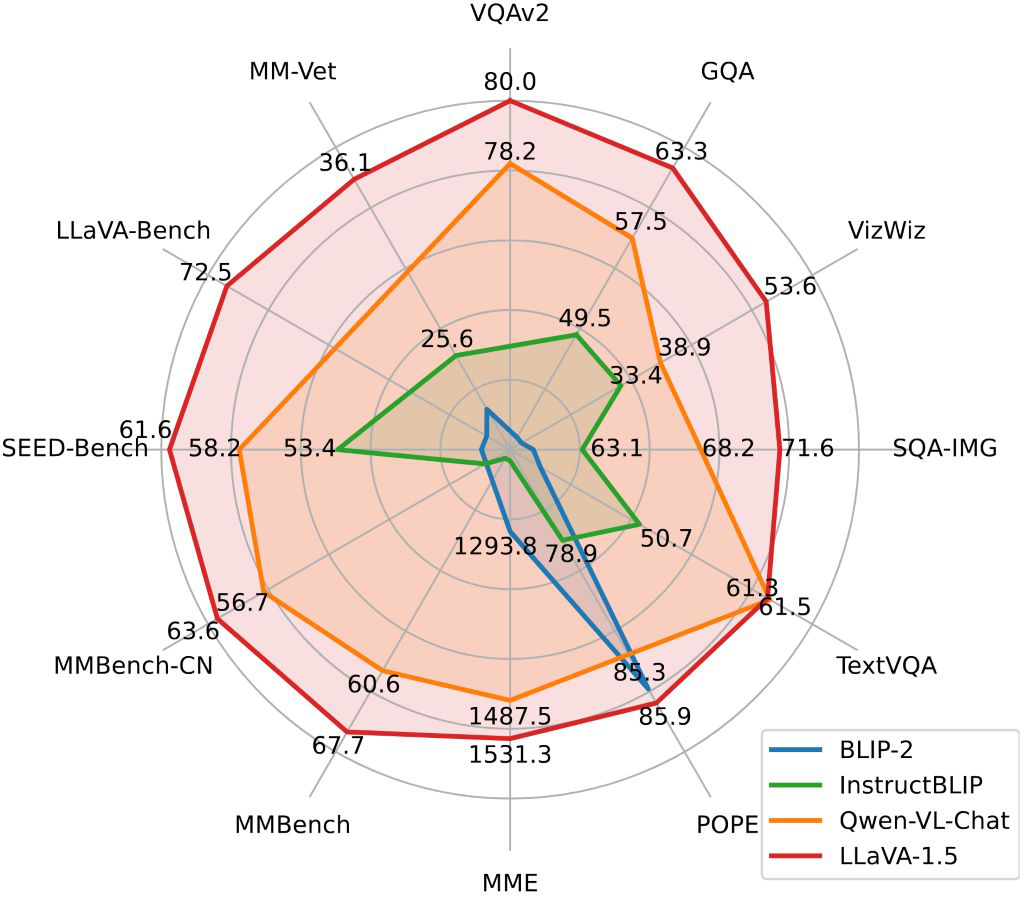

In [51]:
display(image)

In [52]:
# batch process data before llava generate 
# image -> resolution
# text -> tokenizer

inputs = processor(prompts, images, return_tensors="pt", padding=True, truncation=True,)
print(inputs.input_ids.shape)
print(inputs.attention_mask.shape)
print(inputs.pixel_values.shape)
print(inputs.image_sizes)

# print(inputs.input_ids)

torch.Size([3, 22])

torch.Size([3, 22])

torch.Size([3, 5, 3, 336, 336])

tensor([[ 899, 1024],
        [1024,  899],
        [1088, 1088]])

In [53]:
print(processor.decode(inputs.input_ids[0], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[1], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[2], skip_special_tokens=False))

print('-'*50)
print(processor.decode(inputs.input_ids[0][0], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][1], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][2], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][3], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][4], skip_special_tokens=False))
print(processor.decode(inputs.input_ids[0][5], skip_special_tokens=False)) # this is special image token
print(inputs.input_ids[0][5])
print('config 指定了<image> 的token id: ',model_config.image_token_index)
print(processor.tokenizer) # special token


<s> USER: <image>
What is shown in this image? ASSISTANT:<unk><unk><unk>

<s> USER: <image>
What is image show? ASSISTANT:<unk><unk><unk><unk><unk>

<s> USER: <image>
How many people and car in New York City? ASSISTANT:

--------------------------------------------------

<s>

US

ER

:

<image>

tensor(32000)

config 指定了<image> 的token id:  32000

LlamaTokenizerFast(name_or_path='llava-hf/llava-v1.6-vicuna-7b-hf', vocab_size=32000, model_max_length=4096, 
is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': 
'</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
        0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
        1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
        2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
        32000: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, 
special=True),
}

In [54]:
output = model.generate(**inputs, max_new_tokens=10)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [55]:
output

tensor([[    1,  3148,  1001, 29901, 29871, 32000,    13,  5618,   338,  4318,
           297,   445,  1967, 29973,   319,  1799,  9047, 13566, 29901,     0,
             0,     0,  7921,  7921,  7921,  7921,  7921,  7921,  7921,  7921,
          7921,  7921],
        [    1,  3148,  1001, 29901, 29871, 32000,    13,  5618,   338,  1967,
          1510, 29973,   319,  1799,  9047, 13566, 29901,     0,     0,     0,
             0,     0, 14681,  7921,  7921,  7921,  7921,  7921,  7921,  7921,
          7921,  7921],
        [    1,  3148,  1001, 29901, 29871, 32000,    13,  5328,  1784,  2305,
           322,  1559,   297,  1570,  3088,  4412, 29973,   319,  1799,  9047,
         13566, 29901,  7921,  7921,  7921,  7921,  7921,  7921,  7921,  7921,
          7921,  7921]])

In [56]:
print(processor.decode(output[0], skip_special_tokens=False))
print(processor.decode(output[1], skip_special_tokens=False))
print(processor.decode(output[2], skip_special_tokens=False))

<s> USER: <image>
What is shown in this image? ASSISTANT:<unk><unk><unk>argoargoargoargoargoargoargoargoargoargo

<s> USER: <image>
What is image show? ASSISTANT:<unk><unk><unk><unk><unk> delloargoargoargoargoargoargoargoargoargo

<s> USER: <image>
How many people and car in New York City? ASSISTANT:argoargoargoargoargoargoargoargoargoargo

In [57]:
inputs.pixel_values[0,0,...].shape
inputs.pixel_values[0,0,0,:10,:10]

tensor([[1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303],
        [1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303, 1.9303,
         1.9303]])

---

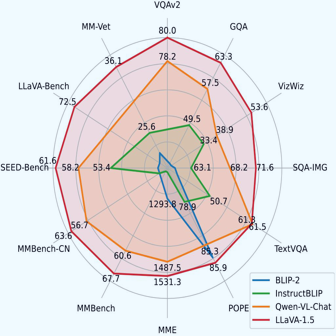

---

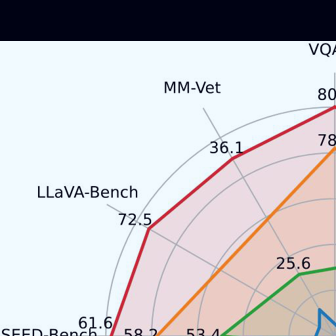

---

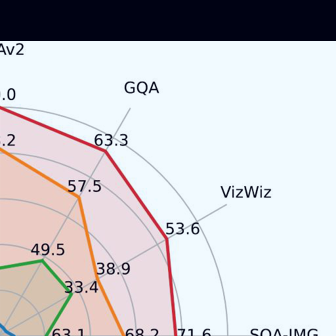

---

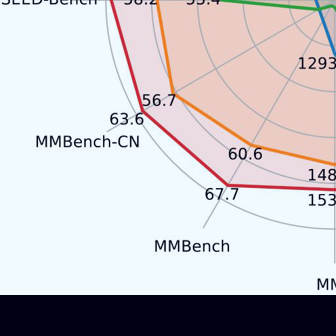

---

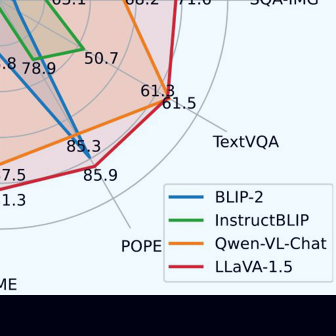

In [83]:
import torchvision.transforms as transforms
def display_pix_values(images):
    # todo：调整RGB通道
    l,_,_,_ = images.shape
    transform = transforms.ToPILImage()
    for i in range(l):# 将归一化后的值缩放到0-255范围
        transform = transforms.ToPILImage()
        tensor = images[i]
        image = (tensor - tensor.min()) / (tensor.max() - tensor.min())
        image = transform(image)
        print('---')
        display(image)
display_pix_values(inputs.pixel_values[0,...])